In [1]:
# **Шаг 1: Установка и импорт библиотек**
!pip install bertopic
!pip install sentence-transformers
!pip install faiss-cpu
!pip install umap-learn

In [30]:
# Импортируем библиотеки
from bertopic import BERTopic
import faiss
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import umap

In [28]:
# **Шаг 2: Загрузка модели и индекса**
# Пути к сохраненным моделям
bertopic_model_path = "../models/bertopic_model/bertopic_model.pkl"
faiss_index_path = "../models/faiss_index/faiss_index.pkl"
bert_path = "../models/bert_model/fine_tuned_model"
embeddings_path = "../data/processed/embeddings_and_indices.npz"
data_path = "../data/processed/cleaned_dataset.csv"

In [5]:
# Загрузка модели BERTopic
topic_model = BERTopic.load(bertopic_model_path)
print("Модель BERTopic успешно загружена.")

Модель BERTopic успешно загружена.


In [6]:
# Загрузка FAISS индекса
with open(faiss_index_path, "rb") as f:
    faiss_index = pickle.load(f)
print("FAISS индекс успешно загружен.")

FAISS индекс успешно загружен.


In [9]:
# Загрузка модели эмбеддингов
embedding_model = SentenceTransformer(bert_path)
print("Модель эмбеддингов успешно загружена.")

No sentence-transformers model found with name ../models/bert_model/fine_tuned_model. Creating a new one with mean pooling.
Some weights of BertModel were not initialized from the model checkpoint at ../models/bert_model/fine_tuned_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель эмбеддингов успешно загружена.


In [25]:
embeddings = np.load(embeddings_path)["embeddings"]
print("Эмбеддинги коллекции документов успешно загружены.")

Эмбеддинги коллекции документов успешно загружены.


In [32]:
artefact_catalog_df = pd.read_csv(data_path)
print("Коллекция документов успешно загружена.")

Коллекция документов успешно загружена.


# Пример текста

In [14]:
new_text = """
Российская академия художеств и Московский государственный академический художественный институт имени В.И. Сурикова при РАХ представляют выставочный проект, приуроченный к 30-летию мастерской Николая Андронова (1929-1998), Павла Никонова и Юрия Шишкова (1940-2020).
Провокационное название выставки «Право на ошибку», демонстрирующей около 150 живописных полотен и графических листов, обнажает множество скрытых тем и идей, неизбежно приводящих к выводу не только о допустимости, но даже о необходимости совершения ошибочных действий в творчестве. Именно это способствует поиску и, что важнее, обретению истинности художественного решения, когда процесс, а не результат, становится самоцелью. В экспозиции будут представлены произведения классика отечественной живописи, народного художника РФ и академика Российской академии художеств Павла Фёдоровича Никонова, заслуженного художника РФ и академика РАХ Юрия Алексеевича Шишкова, а также работы более 20 учеников и выпускников мастерской, среди которых: Виталий Беспятый, Павел Боркунов, Евгения Буравлёва, Елена Бурыкина-Никонова, Ольга Гавришева, Елена Гостюшина, Дмитрий Грачёв, Ольга Гуревич, Айсулу Кадыржанова, Екатерина Клочкова, Евгения Косушкина, Дарья Котлярова, Никита Кулинич, Галина Логвиненко, Владимир Онищук, Павел Отдельнов, Егор Плотников, Ирина Привознова, Полина Рыбакова, Михаил Смирнов, Айгерим Сыздыкова, Роман Усачёв, Ирина Филатова, Елена Цицулина, Татьяна Чурсина, Руслан Ямбушев и Юлия Эрдни Араева.
"""

# Кейс 1: Определение темы для нового текста

In [15]:
def test_new_text(text, embedding_model, topic_model):
    # Генерация эмбеддинга
    query_embedding = embedding_model.encode([text])

    # Определение темы
    query_topic, query_probs = topic_model.transform([text], embeddings=query_embedding)
    print(f"Текст: {text}")
    print(f"Тема: {query_topic}, Вероятности: {query_probs}")

test_new_text(new_text, embedding_model, topic_model)

Текст: 
Российская академия художеств и Московский государственный академический художественный институт имени В.И. Сурикова при РАХ представляют выставочный проект, приуроченный к 30-летию мастерской Николая Андронова (1929-1998), Павла Никонова и Юрия Шишкова (1940-2020).
Провокационное название выставки «Право на ошибку», демонстрирующей около 150 живописных полотен и графических листов, обнажает множество скрытых тем и идей, неизбежно приводящих к выводу не только о допустимости, но даже о необходимости совершения ошибочных действий в творчестве. Именно это способствует поиску и, что важнее, обретению истинности художественного решения, когда процесс, а не результат, становится самоцелью. В экспозиции будут представлены произведения классика отечественной живописи, народного художника РФ и академика Российской академии художеств Павла Фёдоровича Никонова, заслуженного художника РФ и академика РАХ Юрия Алексеевича Шишкова, а также работы более 20 учеников и выпускников мастерской, с

# Кейс 2: Поиск похожих текстов через FAISS

In [18]:
def search_similar_texts(query_embedding, faiss_index, k=5):
    # Поиск через FAISS
    D, I = faiss_index.search(query_embedding, k=k)
    print("Похожие тексты:")
    for idx, score in zip(I[0], D[0]):
        print(f"Индекс: {idx}, Схожесть: {score}")
    return I[0], D[0]

# Генерация эмбеддинга для текста
query_embedding = embedding_model.encode([new_text])
query_topic, query_probs = topic_model.transform([new_text], embeddings=query_embedding)
search_similar_texts(query_probs, faiss_index)

Похожие тексты:
Индекс: 4098, Схожесть: 0.017888158559799194
Индекс: 8836, Схожесть: 0.017888158559799194
Индекс: 16130, Схожесть: 0.017888158559799194
Индекс: 22276, Схожесть: 0.017888158559799194
Индекс: 32805, Схожесть: 0.017888158559799194


(array([ 4098,  8836, 16130, 22276, 32805]),
 array([0.01788816, 0.01788816, 0.01788816, 0.01788816, 0.01788816],
       dtype=float32))

# Кейс 3: Формирование ответа для пользователя

In [19]:
def generate_response(texts, topics):
    response = "🎯 *Рекомендации на основе вашего запроса:*\n"
    for i, (text, topic) in enumerate(zip(texts, topics)):
        response += f"🔹 *Текст {i+1}*\nТема: {topic}\nОписание: {text}\n"
    print("Ответ пользователю:")
    print(response)
    return response

# Пример текстов и тем
texts = ["Текст 1", "Текст 2", "Текст 3"]  # Замените на реальные тексты
topics = [0, 1, 2]
response = generate_response(texts, topics)

Ответ пользователю:
🎯 *Рекомендации на основе вашего запроса:*
🔹 *Текст 1*
Тема: 0
Описание: Текст 1
🔹 *Текст 2*
Тема: 1
Описание: Текст 2
🔹 *Текст 3*
Тема: 2
Описание: Текст 3



# Визуализация

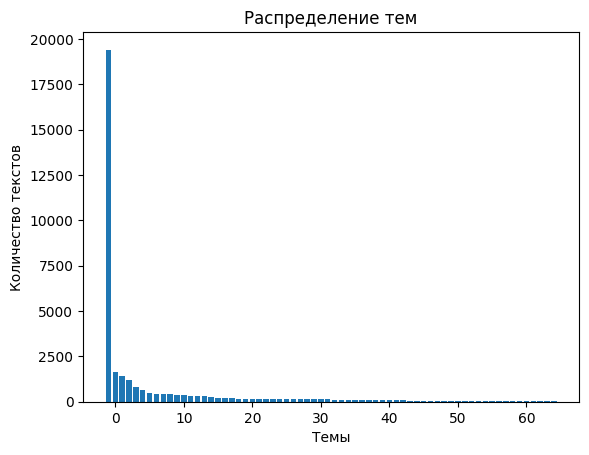

In [22]:
def plot_topic_distribution(topic_model):
    topic_info = topic_model.get_topic_info()
    plt.bar(topic_info["Topic"], topic_info["Count"])
    plt.xlabel("Темы")
    plt.ylabel("Количество текстов")
    plt.title("Распределение тем")
    plt.show()

plot_topic_distribution(topic_model)